In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
#create inspector and connect it to engine
inspector = inspect(engine)

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [9]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
#Use inspector to print column names within the station table and their types
station_columns = inspector.get_columns('station')
for column in station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
#Use inspector to print column names within the measurement table and their types
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
for row in session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1):
    most_recent_date = row.date
    most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d').date()
    print(most_recent_date)

2017-08-23


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)
print(one_year_ago)

2016-08-23


In [18]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()
for data in precipitation_data:
    print(f"Date: {data.date}, Precipitation: {data.prcp}")

Date: 2016-08-23, Precipitation: 0.0
Date: 2016-08-23, Precipitation: 0.15
Date: 2016-08-23, Precipitation: 0.05
Date: 2016-08-23, Precipitation: None
Date: 2016-08-23, Precipitation: 0.02
Date: 2016-08-23, Precipitation: 1.79
Date: 2016-08-23, Precipitation: 0.7
Date: 2016-08-24, Precipitation: 0.08
Date: 2016-08-24, Precipitation: 2.15
Date: 2016-08-24, Precipitation: 2.28
Date: 2016-08-24, Precipitation: None
Date: 2016-08-24, Precipitation: 1.22
Date: 2016-08-24, Precipitation: 2.15
Date: 2016-08-24, Precipitation: 1.45
Date: 2016-08-25, Precipitation: 0.08
Date: 2016-08-25, Precipitation: 0.08
Date: 2016-08-25, Precipitation: 0.0
Date: 2016-08-25, Precipitation: 0.0
Date: 2016-08-25, Precipitation: 0.21
Date: 2016-08-25, Precipitation: 0.06
Date: 2016-08-25, Precipitation: 0.11
Date: 2016-08-26, Precipitation: 0.0
Date: 2016-08-26, Precipitation: 0.03
Date: 2016-08-26, Precipitation: 0.02
Date: 2016-08-26, Precipitation: 0.04
Date: 2016-08-26, Precipitation: 0.0
Date: 2016-08-26, 

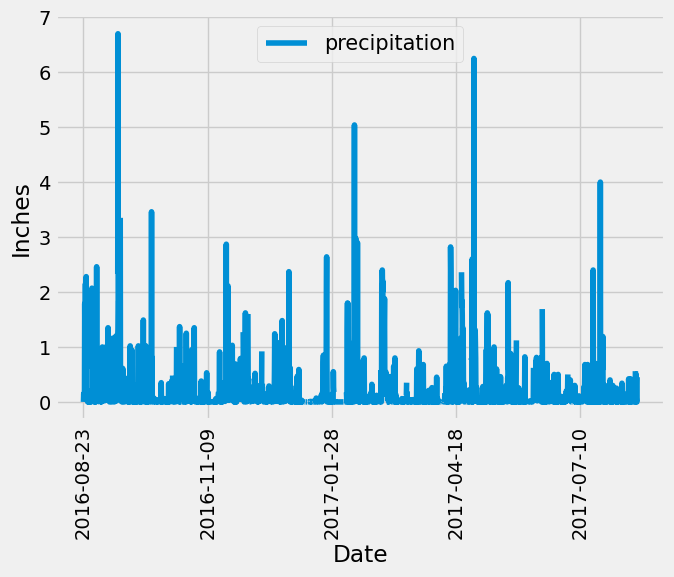

In [15]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns =['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(x='Date', y='Precipitation', figsize=(7, 5), legend=True)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90)
plt.grid(True)
plt.legend(['precipitation'], loc='upper center', bbox_to_anchor=(.5, 1), fontsize=15)
plt.tight_layout
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_summary = pd.DataFrame(precipitation_df['Precipitation'].describe())
precipitation_summary

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations    

[(9,)]

In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                                     group_by(Measurement.station).\
                                     order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_measurements = session.query(Measurement.tobs).\
                        join(Station, Measurement.station == Station.station).\
                        filter(Station.station == 'USC00519281').all()
temperatures = [record.tobs for record in station_measurements]
min_temp = min(temperatures)
max_temp = max(temperatures)
avg_temp = sum(temperatures) / len(temperatures)

temp_stats = (min_temp, max_temp, avg_temp)
temp_stats

(54.0, 85.0, 71.66378066378067)

In [22]:
#Pull most active station id
most_active_station_id = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()[0]
most_active_station_id

'USC00519281'

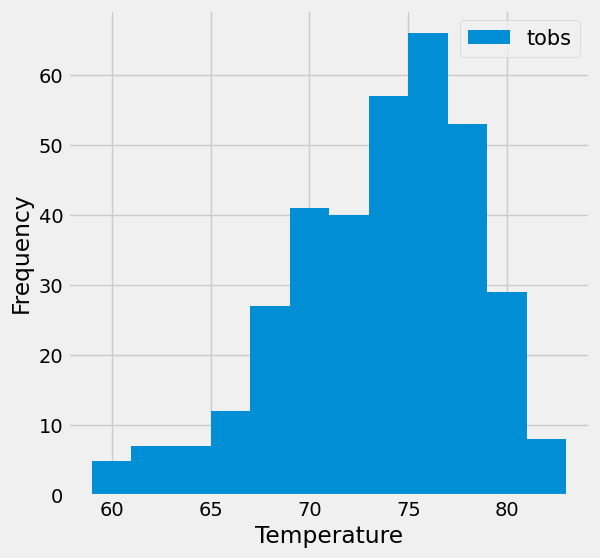

In [30]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= one_year_ago).all()

temp_values = [record.tobs for record in temp_data]

plt.figure(figsize=(6, 6))
plt.hist(temp_values, bins=12)
plt.legend(['tobs'], loc='upper right', bbox_to_anchor=(1, 1), fontsize=15)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Close Session

In [31]:
# Close Session
session.close()